# Concierge Visualizer

## Meta Parameters

In [1]:
result_archive_path = "../result_archive"

## Environment Setup

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os
import shutil

import sys
sys.path.append("../app/dds-adaptive")
from dds_utils import evaluate_partial, read_results_dict, read_profile_info, get_best_configuration

## 1 Single Experiment Tools

### Parameters

In [13]:
Date = "07-20"

NUM_APP = 3
app_names = ["", "dds-adaptive", "dds-adaptive", "dds-adaptive"]
app_names_abbr = ["", "d", "d", "d"]
video_names = ["", "uav-1", "timesquare", "venice-beach"]
video_names_abbr = ["", "u1", "t", "v"]

baseline = False

postfix = None

MIN_BW = 80
MAX_BW = 2100
PROFILE_DELTA = 80

nframes = 125
segment_size = 5 # ⚠️ for now, treating segment_size = batch_size!!!

In [14]:
# Result archive name: Date-#app-app1...-appn-video1...-videon-minbw-maxbw-profiledelta

experiment_name = f"{Date}"
experiment_name += f"-{NUM_APP}"
for i in range(1, NUM_APP + 1):
    experiment_name += f"-{app_names_abbr[i]}"
for i in range(1, NUM_APP + 1):
    experiment_name += f"-{video_names_abbr[i]}"
experiment_name += f"-{MIN_BW}-{MAX_BW}-{PROFILE_DELTA}-5"
if postfix:
    experiment_name += f"-{postfix}"
if baseline:
    experiment_name += "-baseline"

result_path = f"{result_archive_path}/{experiment_name}/app"

### 1.1 Save experiment results to archive folder

In [15]:
if not os.path.exists(result_path):
    os.makedirs(result_path)

for app_idx in range(1, NUM_APP + 1):
    if not os.path.exists(f"{result_path}/app{app_idx}/dataset/{video_names[app_idx]}"):
        os.makedirs(f"{result_path}/app{app_idx}/dataset/{video_names[app_idx]}")
    if not os.path.exists(f"{result_path}/app{app_idx}/workspace"):
        os.makedirs(f"{result_path}/app{app_idx}/workspace")

    shutil.copytree(f"../app/app{app_idx}/data-set/{video_names[app_idx]}/profile", f"{result_path}/app{app_idx}/data-set/{video_names[app_idx]}/profile")
    shutil.copytree(f"../app/app{app_idx}/workspace/logs", f"{result_path}/app{app_idx}/workspace/logs")
    shutil.copytree(f"../app/app{app_idx}/workspace/results", f"{result_path}/app{app_idx}/workspace/results")
    shutil.copy(f"../app/app{app_idx}/workspace/stats", f"{result_path}/app{app_idx}/workspace/stats")

FileExistsError: [Errno 17] File exists: '../result_archive/07-20-3-d-d-d-u1-t-v-80-2100-80-5/app/app1/data-set/uav-1/profile'

### 1.2 Extract bw log from archive folder

In [16]:
logs = [""]
for app_idx in range(1, NUM_APP + 1):
    logs.append(pd.read_csv(f"{result_path}/app{app_idx}/workspace/logs/bandwidth_log", header= None, names=["fid", "bw", "low_res", "high_res", "low_qp", "high_qp", "just_realloc"], sep=",", converters={"just_realloc" : lambda x: x == "True"}))

### 1.3 Video Segmental Analysis

#### 1.3.1 Plot the bandwidth change

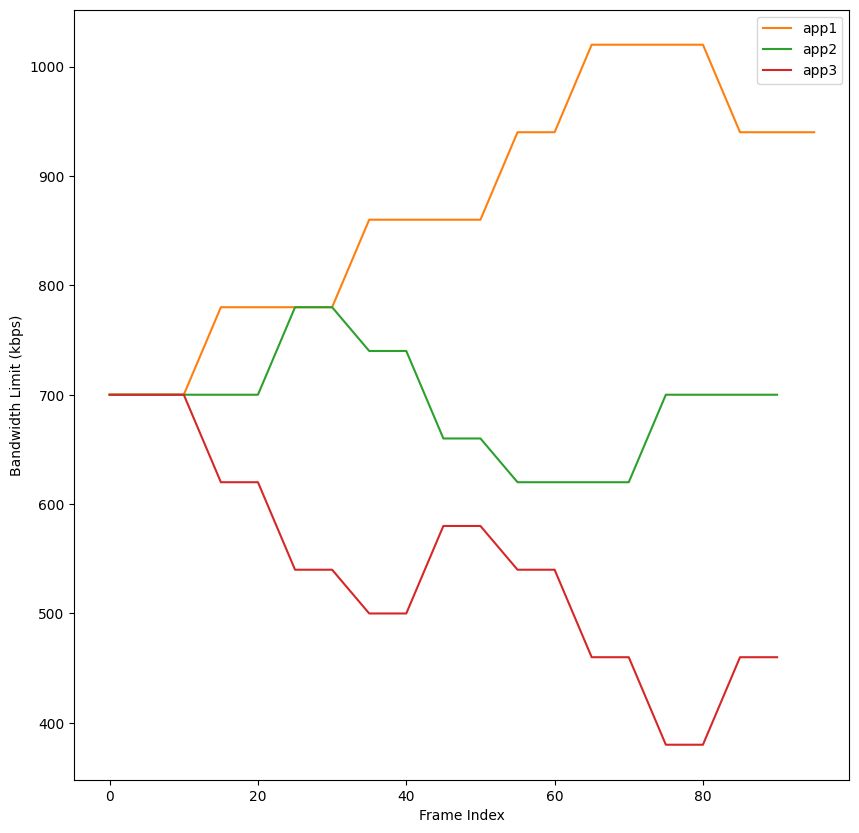

In [17]:
plt.figure(figsize=(10, 10))
for app_idx in range(1, NUM_APP + 1):
    plt.plot(logs[app_idx]['fid'], logs[app_idx]['bw'], label=f"app{app_idx}", color=f"C{app_idx}")

plt.xlabel("Frame Index")
plt.ylabel("Bandwidth Limit (kbps)")

plt.legend()

#### 1.3.2 Segmental f1 score

1.3.2.1 Calculate the segmental f1 score

In [18]:
f1s = [""]
for app_idx in range(1, NUM_APP + 1):
    segment_size = read_profile_info(f"{result_path}/app{app_idx}/data-set/{video_names[app_idx]}/profile/profile_info.yml")['segment_size']

    result_dict = read_results_dict(f"{result_path}/app{app_idx}/workspace/results/{video_names[app_idx]}_adaptive_{MAX_BW}_0.0_twosides_batch_5_0.5_0.8_0.4")
    gt_dict = read_results_dict(f"{result_path}/app{app_idx}/workspace/results/{video_names[app_idx]}_gt")

    f1s.append(pd.DataFrame({'fid':[], 'f1':[]}))

    for start_frame in range(0, nframes, segment_size):
        tp, fp, fn, _, _, _, f1 = evaluate_partial(
            min_fid = start_frame, 
            max_fid = start_frame + segment_size - 1,
            map_dd = result_dict,
            map_gt = gt_dict,
            gt_confid_thresh = 0.3, 
            mpeg_confid_thresh = 0.5, 
            max_area_thresh_gt = 0.4, 
            max_area_thresh_mpeg = 0.4)
        
        f1s[app_idx].loc[len(f1s[app_idx])] = {'fid': start_frame, 'f1': f1}   

FileNotFoundError: [Errno 2] No such file or directory: '../result_archive/07-20-3-d-d-d-u1-t-v-80-2100-80-5/app/app1/workspace/results/uav-1_adaptive_2100_0.0_twosides_batch_5_0.5_0.8_0.4'

1.3.2.2 Plot the segmental f1 score

In [19]:
plt.figure()

f1s[0] = f1s[1].copy()
for app_idx in range(1, NUM_APP + 1):
    plt.plot(f1s[app_idx]['fid'], f1s[app_idx]['f1'], label=f"app{app_idx}-CON")
    if (app_idx > 1):
        f1s[0]['f1'] += f1s[app_idx]['f1']


plt.plot(f1s[0]['fid'], f1s[0]['f1'], label=f"app-CON-SUM")

plt.xlabel("Starting Frame Index")
plt.ylabel("Segment F1 Score")

plt.legend()

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

#### 1.3.3 Accuracy Sensitivity (offline F1 Diff)

1.3.3.1 Calculate the accuracy sensitivity

In [11]:
upward_sensitivities = [""]
downward_sensitivies = [""]

for app_idx in range(1, NUM_APP + 1):
    upward_sensitivities.append(pd.DataFrame({'fid': [], 'up_sens':[]}))
    downward_sensitivies.append(pd.DataFrame({'fid': [], 'down_sens':[]}))

    for profile_no in range(nframes//segment_size):
        bandwidth = logs[app_idx].loc[profile_no]['bw']
        _, _, _, _, f1_mid = get_best_configuration(bandwidth, f'{result_path}/app{app_idx}/dataset/{video_names[app_idx]}/profile/profile-{profile_no}.csv')
        _, _, _, _, f1_high = get_best_configuration(bandwidth + PROFILE_DELTA, f'{result_path}/app{app_idx}/dataset/{video_names[app_idx]}/profile/profile-{profile_no}.csv')
        _, _, _, _, f1_low = get_best_configuration(bandwidth - PROFILE_DELTA, f'{result_path}/app{app_idx}/dataset/{video_names[app_idx]}/profile/profile-{profile_no}.csv')

        upward_sensitivities[app_idx].loc[len(upward_sensitivities[app_idx])] = {'fid': profile_no * segment_size, 'up_sens': f1_high - f1_mid}
        downward_sensitivies[app_idx].loc[len(downward_sensitivies[app_idx])] = {'fid': profile_no * segment_size, 'down_sens': f1_mid - f1_low}


1.3.3.2 Plot the accuracy sensitivity

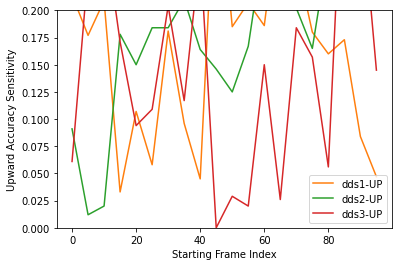

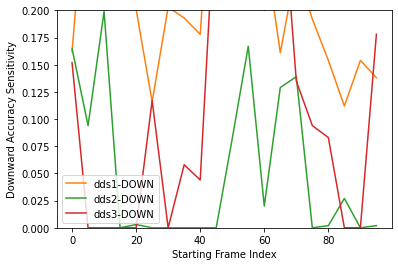

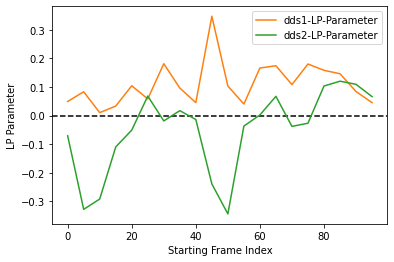

In [10]:
# Upward Sensitivity
plt.figure()

for app_idx in range(1, NUM_APP + 1):
    plt.plot(upward_sensitivities[app_idx]['fid'], upward_sensitivities[app_idx]['up_sens'], label=f"dds{app_idx}-UP", color=f"C{app_idx}")

plt.ylim(0, 0.2)

plt.xlabel("Starting Frame Index")
plt.ylabel("Upward Accuracy Sensitivity")

plt.legend()

# Downward Sensitivity
plt.figure()

for app_idx in range(1, NUM_APP + 1):
    plt.plot(downward_sensitivies[app_idx]['fid'], downward_sensitivies[app_idx]['down_sens'], label=f"dds{app_idx}-DOWN", color=f"C{app_idx}")

plt.xlabel("Starting Frame Index")
plt.ylabel("Downward Accuracy Sensitivity")

plt.ylim(0, 0.2)

plt.legend()

# Upward Sensitivity - Downward Sensitivity
plt.figure()

plt.axhline(y=0, color='k', linestyle='--')
plt.plot(downward_sensitivies[app_idx]['fid'], upward_sensitivities[1]['up_sens'] - downward_sensitivies[2]['down_sens'], label=f"dds{1}-LP-Parameter", color=f"C1")
plt.plot(downward_sensitivies[app_idx]['fid'], upward_sensitivities[2]['up_sens'] - downward_sensitivies[1]['down_sens'], label=f"dds{2}-LP-Parameter", color=f"C2")

plt.xlabel("Starting Frame Index")
plt.ylabel("LP Parameter")

plt.legend()

#### 1.3.4 Save log files to result

In [10]:
for app_idx in range(1, NUM_APP + 1):
    log_complete = pd.concat([logs[app_idx], f1s[app_idx]['f1']], axis=1)
    # log_complete = pd.concat([logs[app_idx], f1s[app_idx]['f1'], upward_sensitivities[app_idx]['up_sens'], downward_sensitivies[app_idx]['down_sens']], axis=1)
    log_complete.to_csv(f"{result_path}/app{app_idx}/workspace/logs/log", index=False)

### 1.4 Reallocation Segmental Analysis

In [7]:
logs_realloc = [""]
for app_idx in range(1, NUM_APP + 1):
    logs_realloc.append(logs[app_idx][logs[app_idx]['just_realloc'] == True])
    logs_realloc[app_idx] = logs_realloc[app_idx].append(logs[app_idx].iloc[0])

    # logs_realloc[app_idx].sort_values(by=['fid'], inplace=True)
    logs_realloc[app_idx] = logs_realloc[app_idx].append(logs[app_idx].iloc[-1])

    logs_realloc[app_idx].sort_values(by=['fid'], inplace=True)
    logs_realloc[app_idx] = logs_realloc[app_idx].reset_index(drop=True)

#### 1.4.1 Bandwidth Allocation

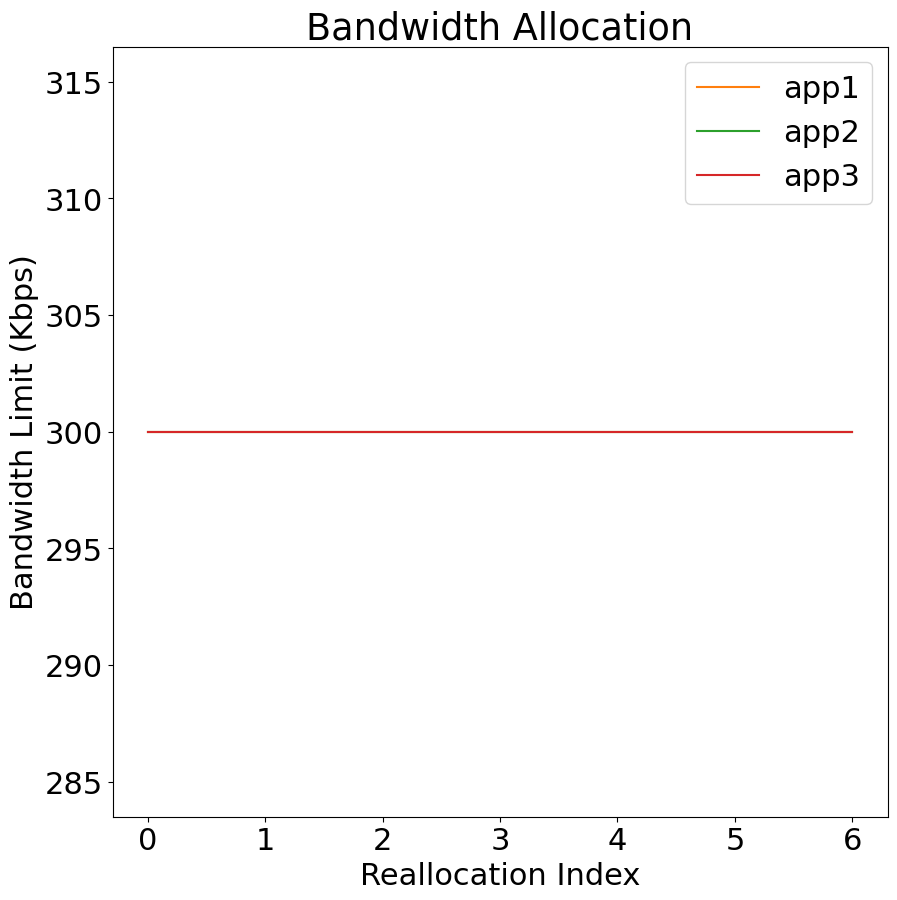

In [8]:
plt.figure(figsize=(10, 10))

plt.rcParams.update({'font.size': 22})

for app_idx in range(1, NUM_APP + 1):
    plt.plot(logs_realloc[app_idx].iloc[0:-1].index, logs_realloc[app_idx]['bw'].iloc[0:-1], label=f"app{app_idx}", color=f"C{app_idx}")

plt.title("Bandwidth Allocation")
plt.xlabel("Reallocation Index")
plt.ylabel("Bandwidth Limit (Kbps)")

plt.legend()

#### 1.4.2 Segmental f1 score

In [9]:
f1s_realloc = [""]
for app_idx in range(1, NUM_APP + 1):
    result_dict = read_results_dict(f"{result_path}/app{app_idx}/workspace/results/{video_names[app_idx]}_adaptive_{MAX_BW}_0.0_twosides_batch_5_0.5_0.8_0.4")
    gt_dict = read_results_dict(f"{result_path}/app{app_idx}/workspace/results/{video_names[app_idx]}_gt")

    f1s_realloc.append(pd.DataFrame({'reallocation_index':[], 'f1':[]}))

    for reallocation_index in range(0, len(logs_realloc[app_idx]) - 1):
        start_frame = logs_realloc[app_idx].iloc[reallocation_index]['fid']
        end_frame = logs_realloc[app_idx].iloc[reallocation_index + 1]['fid'] - 1

        if reallocation_index == len(logs_realloc[app_idx]) - 2: # if the last reallocation segment
            # should include the last batch
            end_frame = logs_realloc[app_idx].iloc[reallocation_index + 1]['fid'] + segment_size - 1 


        tp, fp, fn, _, _, _, f1 = evaluate_partial(
            min_fid = start_frame, 
            max_fid = end_frame,
            map_dd = result_dict,
            map_gt = gt_dict,
            gt_confid_thresh = 0.3, 
            mpeg_confid_thresh = 0.5, 
            max_area_thresh_gt = 0.4, 
            max_area_thresh_mpeg = 0.4)
        
        f1s_realloc[app_idx].loc[len(f1s_realloc[app_idx])] = {'reallocation_index': reallocation_index, 'f1': f1}   

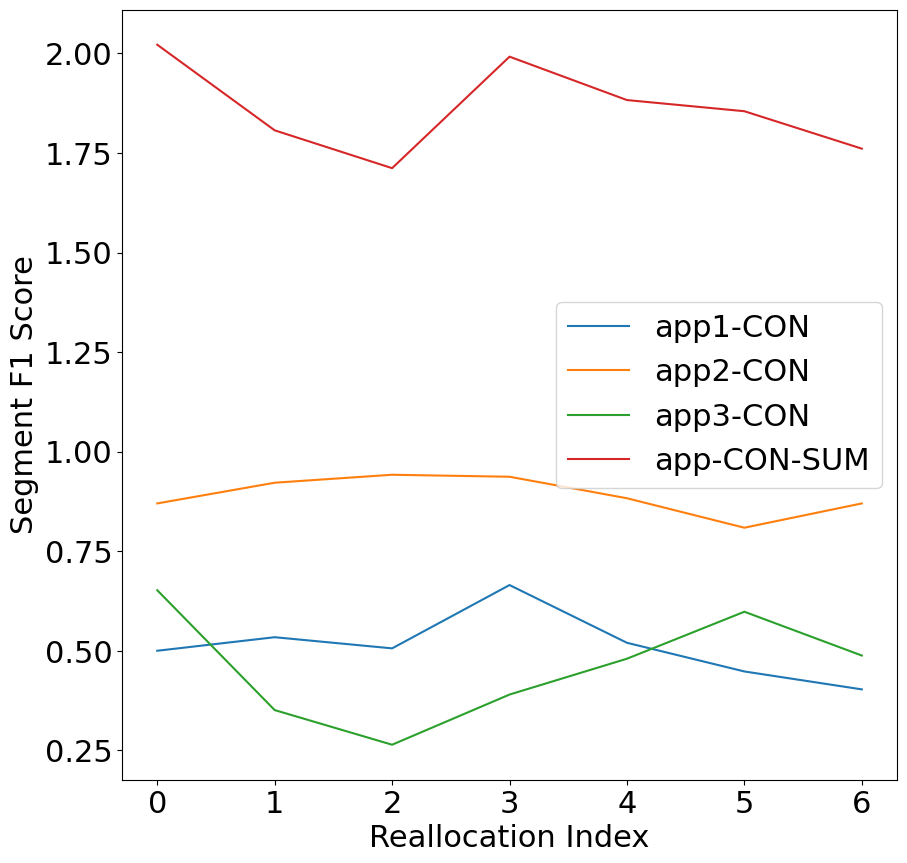

In [10]:
plt.figure(figsize=(10, 10))

f1s_realloc[0] = f1s_realloc[1].copy()
for app_idx in range(1, NUM_APP + 1):
    plt.plot(f1s_realloc[app_idx]['reallocation_index'], f1s_realloc[app_idx]['f1'], label=f"app{app_idx}-CON")
    if (app_idx > 1):
        f1s_realloc[0]['f1'] += f1s_realloc[app_idx]['f1']


plt.plot(f1s_realloc[0]['reallocation_index'], f1s_realloc[0]['f1'], label=f"app-CON-SUM")

plt.xlabel("Reallocation Index")
plt.ylabel("Segment F1 Score")

plt.legend()

#### 1.4.3 Save log files to result

In [11]:
for app_idx in range(1, NUM_APP + 1):
    log_complete_realloc = pd.concat([logs_realloc[app_idx], f1s_realloc[app_idx]['f1']], axis=1)
    log_complete_realloc.to_csv(f"{result_path}/app{app_idx}/workspace/logs/log_realloc", index=False)

## 2 Baseline Comparison

### Parameters

In [12]:
Date = "05-24"
NUM_APP = 3
app_names = ["", "awstream-adaptive", "dds-adaptive", "dds-adaptive"]
app_names_abbr = ["", "a", "d", "d"]
video_names = ["", "uav-1", "coldwater", "roppongi"]
video_names_abbr = ["", "u1", "c", "r"]

postfix = None



MIN_BW = 0
MAX_BW = 900
PROFILE_DELTA = 80

nframes = 100

experiment_name = f"{Date}"
experiment_name += f"-{NUM_APP}"
for i in range(1, NUM_APP + 1):
    experiment_name += f"-{app_names_abbr[i]}"
for i in range(1, NUM_APP + 1):
    experiment_name += f"-{video_names_abbr[i]}"
experiment_name += f"-{MIN_BW}-{MAX_BW}-{PROFILE_DELTA}-5"

if postfix:
    experiment_name += f"-{postfix}"

baseline_experiment_name = experiment_name + "-baseline"

### 2.1 Segmental Analysis

#### 2.1.1 Extract log from archive folder

In [21]:
log = [""]
log_baseline = [""]
reallocation_segment_mode = True

if reallocation_segment_mode:
    for app_idx in range(1, NUM_APP + 1):
        log.append(pd.read_csv(f"{result_archive_path}/{experiment_name}/app/app{app_idx}/workspace/logs/log_realloc"))
#         log_baseline.append(pd.read_csv(f"{result_archive_path}/{baseline_experiment_name}/app/app{app_idx}/workspace/logs/log_realloc"))
else:
    for app_idx in range(1, NUM_APP + 1):
        log.append(pd.read_csv(f"{result_archive_path}/{experiment_name}/app/app{app_idx}/workspace/logs/log"))
        log_baseline.append(pd.read_csv(f"{result_archive_path}/{baseline_experiment_name}/app/app{app_idx}/workspace/logs/log"))

log[0] = log[1].copy()
# log_baseline[0] = log_baseline[1].copy()
for app_idx in range(2, NUM_APP + 1):
    log[0]['f1'] += log[app_idx]['f1']
#     log_baseline[0]['f1'] += log_baseline[app_idx]['f1']
log

[    fid      bw  low_res  high_res  low_qp  high_qp  just_realloc     f1
 0     0   700.0      0.8       0.8      34       28         False  2.142
 1     5   700.0      0.5       1.0      32       24          True  0.000
 2    15   780.0      0.7       0.9      34       26          True  1.254
 3    25   780.0      0.8       1.0      34       26          True  1.519
 4    35   860.0      0.8       0.8      34       26          True  1.943
 5    45   860.0      0.5       1.0      32       26          True  1.930
 6    55   940.0      0.7       0.9      32       28          True  1.531
 7    65  1020.0      0.5       1.0      30       24          True  1.507
 8    75  1020.0      0.6       0.9      34       26          True  1.389
 9    85   940.0      0.6       0.9      34       28          True  1.151
 10   95   940.0      0.5       0.5      32       28         False    NaN,
     fid      bw  low_res  high_res  low_qp  high_qp  just_realloc     f1
 0     0   700.0      0.8       0.8  

In [14]:
log[1]

,fid,bw,low_res,high_res,low_qp,high_qp,just_realloc,f1
0,0,300.0,0.7,0.7,34,28,False,0.500
1,5,300.0,0.6,0.8,34,24,True,0.546
2,20,300.0,0.7,0.7,34,28,True,0.501
3,35,300.0,0.6,0.6,34,26,True,0.610
4,50,300.0,0.5,0.5,32,24,True,0.617
5,65,380.0,0.5,0.9,32,26,True,0.539
6,85,380.0,0.5,0.5,32,24,True,0.455
7,95,380.0,0.5,1.0,34,24,False,NaN


#### 2.1.2 Plot Segmental F1 Score

In [15]:
def f1_fid(log, log_baseline, app_idx):
    plt.figure(figsize=(10, 10))

    if reallocation_segment_mode:
        plt.plot(log_baseline[app_idx].index, log_baseline[app_idx]['f1'], label=f"dds{app_idx}-BASELINE", color=f"C{app_idx}", linestyle='dashed')
        plt.plot(log[app_idx].index, log[app_idx]['f1'], label=f"dds{app_idx}-CON", color=f"C{app_idx}")

        plt.xlim(0, log_baseline[app_idx].index[-2])

        plt.xlabel("Reallocation Index")
    else:
        plt.plot(log_baseline[app_idx]['fid'], log_baseline[app_idx]['f1'], label=f"dds{app_idx}-BASELINE", color=f"C{app_idx}", linestyle='dashed')
        plt.plot(log[app_idx]['fid'], log[app_idx]['f1'], label=f"dds{app_idx}-CON", color=f"C{app_idx}")

        plt.xlim(0, nframes)

        plt.xlabel("Frame Index")

    plt.ylim(-0.1, 1.1)
    plt.ylabel("Segment F1 Score")

    plt.legend()

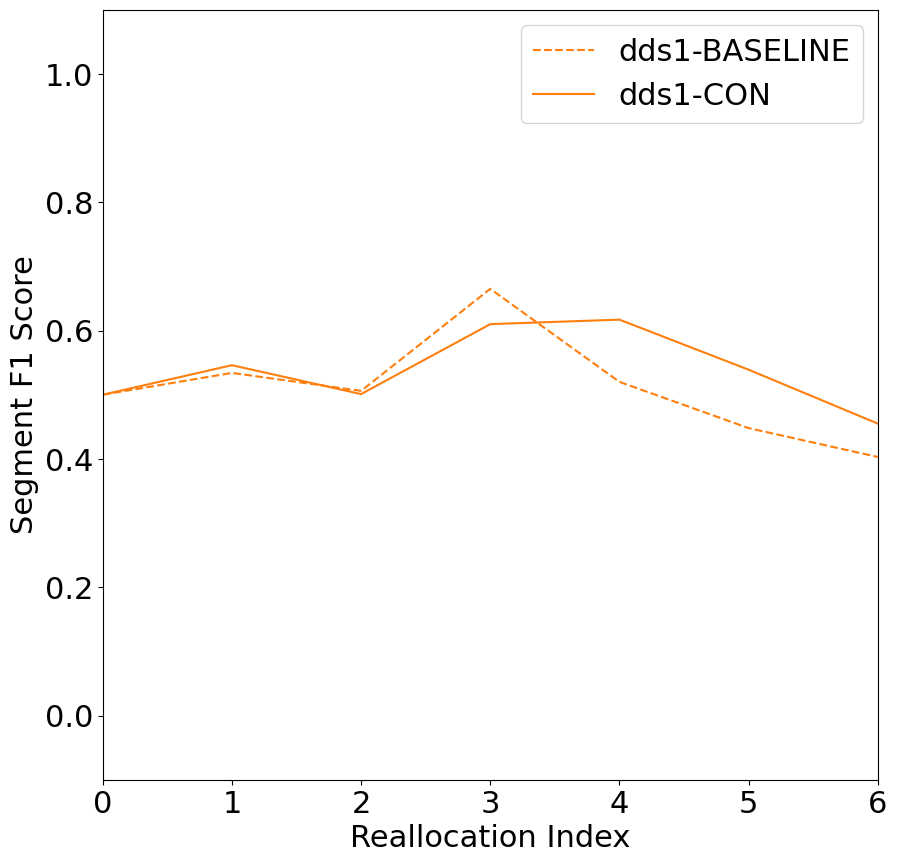

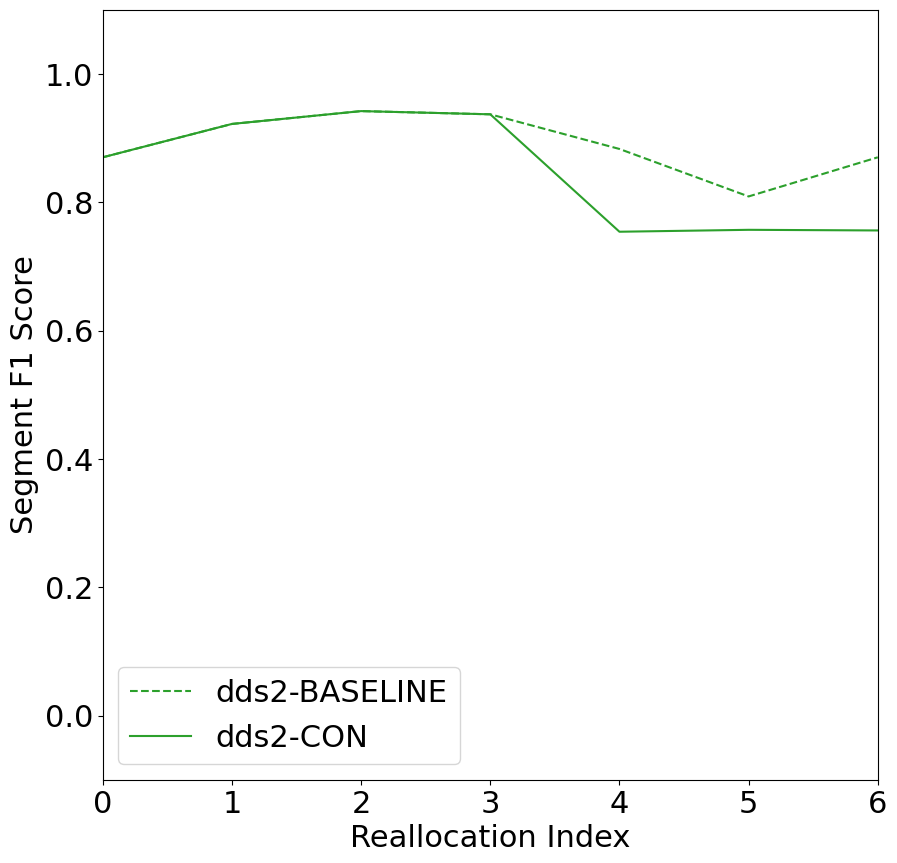

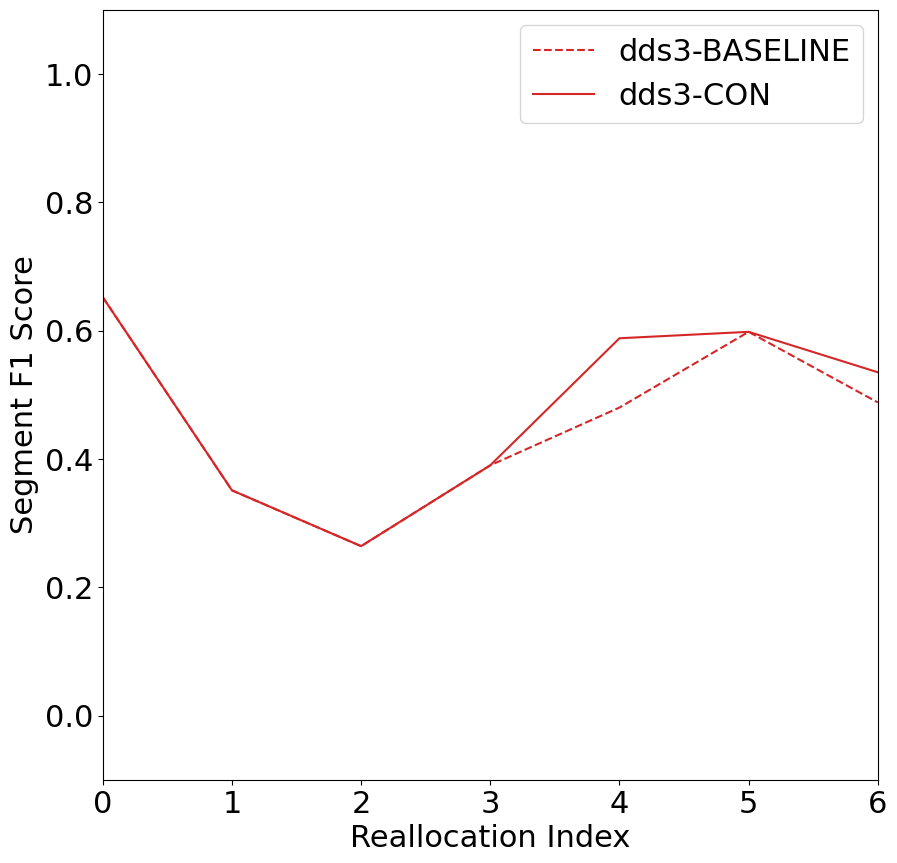

In [16]:
for app_idx in range(1, NUM_APP + 1):
    f1_fid(log, log_baseline, app_idx)

#### 2.1.3 Plot Segmental Sum of F1 Score

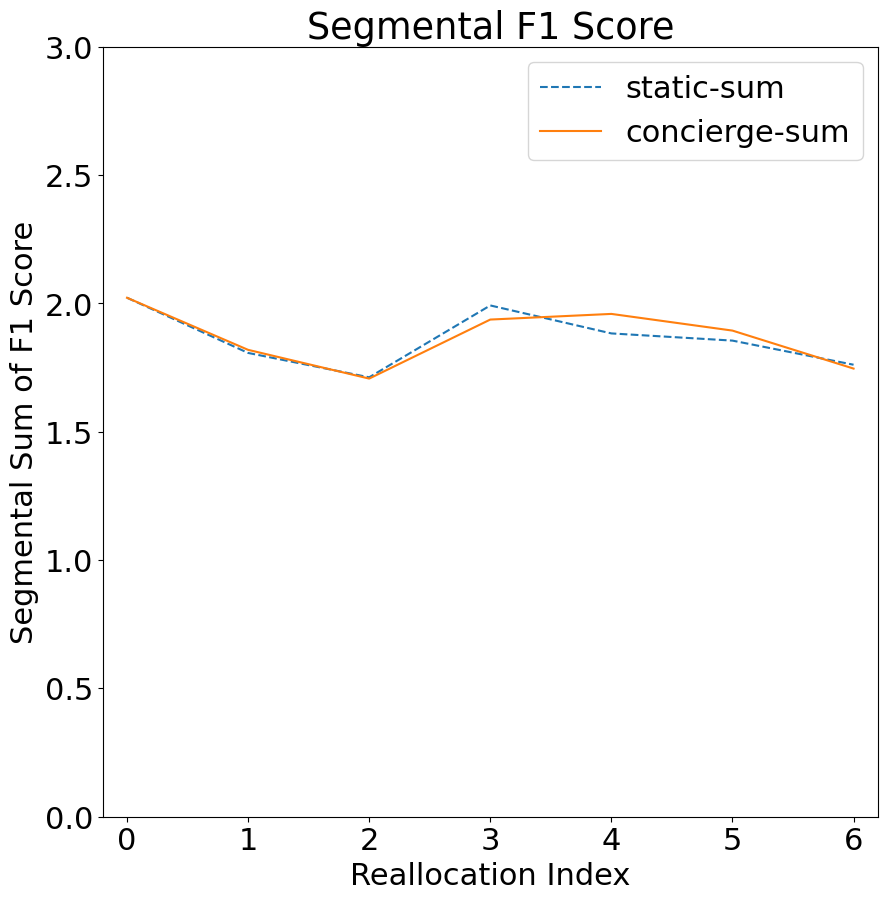

In [17]:
plt.figure(figsize=(10, 10))

plt.rcParams.update({'font.size': 22})

if reallocation_segment_mode:
    plt.plot(log_baseline[0].index, log_baseline[0]['f1'], label=f"static-sum", linestyle='dashed')
    plt.plot(log[0].index, log[0]['f1'], label=f"concierge-sum")

    plt.xlim(-0.2, log_baseline[0].index[-2] + 0.2)
    plt.xlabel("Reallocation Index")

else:
    plt.plot(log_baseline[0]['fid'], log_baseline[0]['f1'], label=f"static-sum", linestyle='dashed')
    plt.plot(log[0]['fid'], log[0]['f1'], label=f"concierge-sum")

    plt.xlim(0, nframes)
    plt.xlabel("Frame Index")


plt.ylim(0, 3.0)

plt.title("Segmental F1 Score")
plt.ylabel("Segmental Sum of F1 Score")

plt.legend()

#### 2.1.4 Plot Segmental Difference in Sum of F1 Score

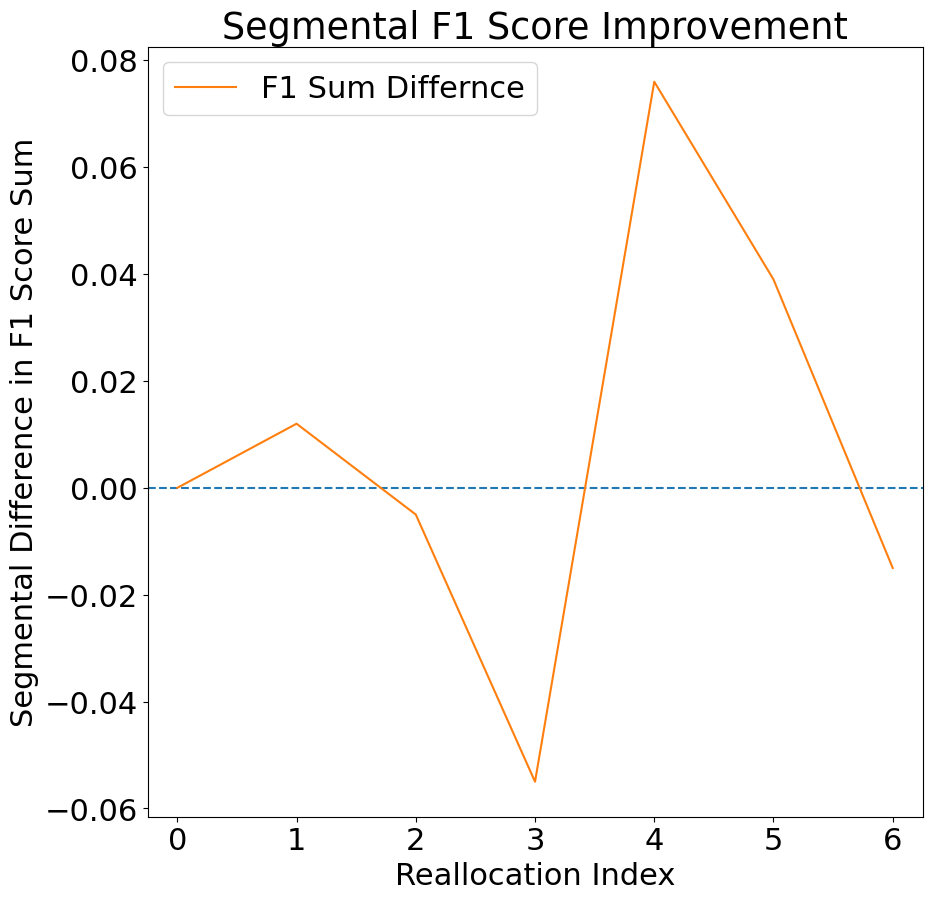

In [18]:
plt.figure(figsize=(10, 10))

plt.axhline(y=0, color='C0', linestyle='--')

if reallocation_segment_mode:
    plt.plot(log_baseline[0].index, log[0]['f1'] - log_baseline[0]['f1'], label=f"F1 Sum Differnce", color=f"C1")

    plt.xlim(-0.25, log_baseline[0].index[-2] + 0.25)
    plt.xlabel("Reallocation Index")
else:
    plt.plot(log_baseline[0]['fid'], log[0]['f1'] - log_baseline[0]['f1'], label=f"F1 Sum Differnce", color=f"C1")

    plt.xlim(0, nframes)
    plt.xlabel("Frame Index")

plt.title("Segmental F1 Score Improvement")
plt.ylabel("Segmental Difference in F1 Score Sum")

plt.legend()

# Bandwidth Allocation (Deprecated)

In [22]:
log[1]

,fid,bw,low_res,high_res,low_qp,high_qp,just_realloc,f1
0,0,300.0,0.7,0.7,34,28,False,0.500
1,5,300.0,0.6,0.8,34,24,True,0.546
2,20,300.0,0.7,0.7,34,28,True,0.501
3,35,300.0,0.6,0.6,34,26,True,0.610
4,50,300.0,0.5,0.5,32,24,True,0.617
5,65,380.0,0.5,0.9,32,26,True,0.539
6,85,380.0,0.5,0.5,32,24,True,0.455
7,95,380.0,0.5,1.0,34,24,False,NaN


In [23]:
log_baseline[1]

,fid,bw,low_res,high_res,low_qp,high_qp,just_realloc,f1
0,0,300.0,0.7,0.7,34,28,False,0.500
1,5,300.0,0.6,0.8,34,24,True,0.534
2,25,300.0,0.5,0.5,32,26,True,0.506
3,40,300.0,0.6,0.8,34,24,True,0.665
4,60,300.0,0.5,1.0,32,28,True,0.520
5,75,300.0,0.5,0.7,34,24,True,0.448
6,95,300.0,0.5,1.0,34,24,True,0.403
7,95,300.0,0.5,1.0,34,24,True,NaN


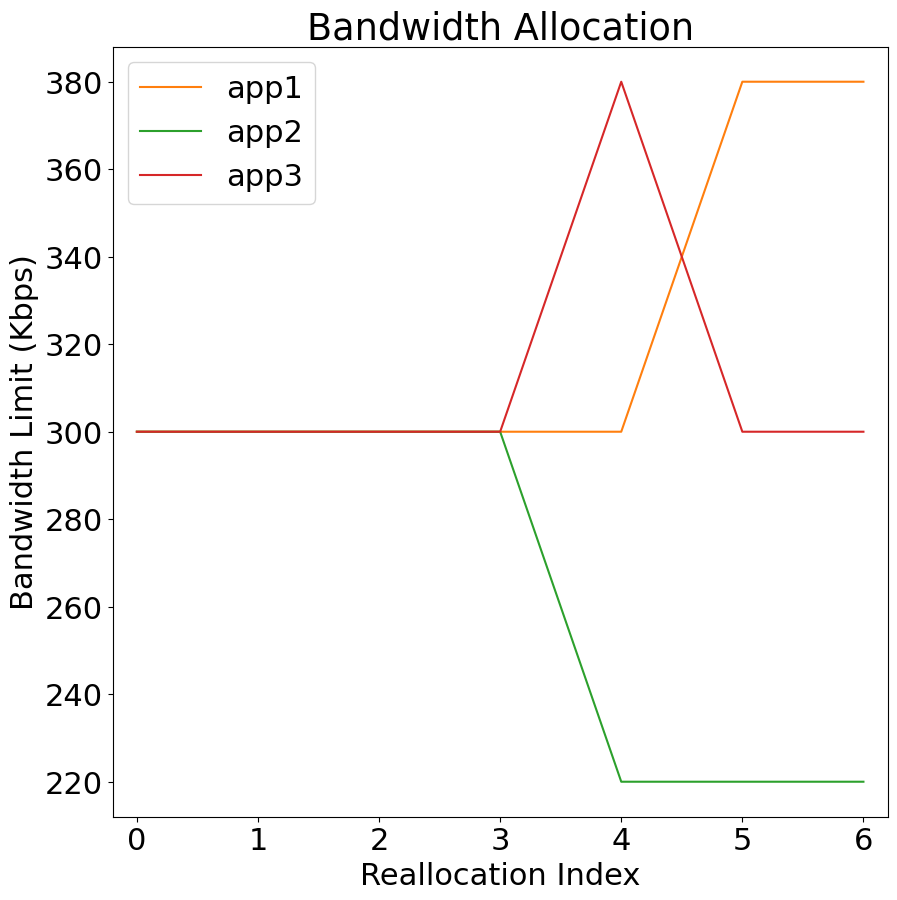

In [24]:
plt.figure(figsize=(10, 10))

if reallocation_segment_mode:
    for app_idx in range(1, NUM_APP + 1):
        plt.plot(log[app_idx].index[0:-1], log[app_idx]['bw'][0:-1], label=f"app{app_idx}", color=f"C{app_idx}")

        plt.xlim(-0.2, log_baseline[app_idx].index[-2] + 0.2)
        plt.xlabel("Reallocation Index")
else:
    for app_idx in range(1, NUM_APP + 1):
        plt.plot(log[app_idx]['fid'], log[app_idx]['bw'], label=f"app{app_idx}", color=f"C{app_idx}")

        plt.xlim(0, nframes)
        plt.xlabel("Frame Index")


# plt.ylim(0.3, 1.25)

plt.title("Bandwidth Allocation")
plt.ylabel("Bandwidth Limit (Kbps)")

plt.legend()

### Accuracy Sensitivity

### Examine `infer_diff`: online-f1

In [13]:
app_idx = 1

low_res_old = 0.6
high_res_old = 0.8
low_qp_old = 40
high_qp_old = 28

low_res_new = 0.8
high_res_new =  0.8
low_qp_new = 36
high_qp_new = 28

min_fid = 65
max_fid = 69

old_results_dict = read_results_dict(f"../app/app{app_idx}/dataset/{video_names[app_idx]}/results/{video_names[app_idx]}_dds_{low_res_old}_{high_res_old}_{low_qp_old}_{high_qp_old}_0.0_twosides_batch_5_0.5_0.8_0.4")
new_results_dict = read_results_dict(f"../app/app{app_idx}/dataset/{video_names[app_idx]}/results/{video_names[app_idx]}_dds_{low_res_new}_{high_res_new}_{low_qp_new}_{high_qp_new}_0.0_twosides_batch_5_0.5_0.8_0.4")


tp, fp, fn, _, _, _, f1 = evaluate_partial(
    min_fid = min_fid, 
    max_fid = max_fid,
    map_dd = old_results_dict,
    map_gt = new_results_dict,
    gt_confid_thresh = 0.3, 
    mpeg_confid_thresh = 0.5, 
    max_area_thresh_gt = 0.4, 
    max_area_thresh_mpeg = 0.4)

print(f1)
print(1-f1)

0.519
0.481
